# SARIMA
Chúng ta sẽ giải thích mô hình này từng phần một. SARIMA(p,d,q)(P,D,Q,s), hay còn gọi là Mô hình hồi quy tự động trung bình động mùa vụ, được định nghĩa như sau:


### AR(p)
Là mô hình hồi quy tự động, tức là hồi quy chuỗi thời gian dựa trên chính nó.
Giả định cơ bản là giá trị hiện tại của chuỗi thời gian phụ thuộc vào các giá trị trước đó với một độ trễ nào đó (hoặc nhiều độ trễ).
Độ trễ lớn nhất trong mô hình được gọi là p.
Để xác định giá trị ban đầu của p, hãy nhìn vào biểu đồ PACF (Partial Autocorrelation Function) và tìm độ trễ lớn nhất có ý nghĩa sau đó các độ trễ khác không còn có ý nghĩa nữa.

###MA(q)
Là mô hình trung bình động, mô hình này không đi sâu vào giá trị chuỗi thời gian mà thay vào đó dựa trên lỗi (error) của chuỗi.
Giả định rằng lỗi hiện tại phụ thuộc vào các lỗi trước đó với một độ trễ, được gọi là q.
Để tìm giá trị ban đầu của q, sử dụng biểu đồ ACF (Autocorrelation Function) và áp dụng logic tương tự như với PACF.
Kết hợp:

$AR(p)+MA(q)=ARMA(p,q)$

Đây chính là Mô hình hồi quy tự động - trung bình động! Nếu chuỗi thời gian là dừng (stationary), nó có thể được mô tả bằng mô hình này.

###I(d)
Bậc sai phân không mùa vụ: Là số lần lấy sai phân không mùa vụ cần thiết để biến chuỗi thời gian trở nên dừng.
Trong trường hợp này, giá trị d thường bằng 1 vì chuỗi đã được lấy sai phân bậc 1.
Khi thêm phần này, chúng ta có ARIMA(p,d,q), một mô hình có thể xử lý dữ liệu không dừng thông qua các sai phân không mùa vụ.

###S(s)
Phần này chịu trách nhiệm mô phỏng tính chu kỳ mùa vụ, với s là chiều dài của chu kỳ mùa vụ.
Thêm vào đó, chúng ta có ba tham số: (P, D, Q)
###P
Bậc hồi quy tự động của thành phần mùa vụ: Được xác định từ biểu đồ PACF.
Tìm các độ trễ có ý nghĩa là bội số của chu kỳ mùa vụ.
Ví dụ: Nếu chu kỳ mùa vụ bằng 24 và các độ trễ 24 và 48 có ý nghĩa trên PACF, thì giá trị P ban đầu là 2.
###Q
Áp dụng logic tương tự với biểu đồ ACF để xác định bậc trung bình động của thành phần mùa vụ.
###D
Bậc sai phân mùa vụ, thường bằng 1 hoặc 0, tùy thuộc vào việc chuỗi có được lấy sai phân mùa vụ hay không.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [3]:
# data = pd.read_csv('/content/data_sample_for_forcasting.csv', index_col=['Date'])
data = pd.read_csv('ads.csv', index_col=['Date'], parse_dates=['Date'])


In [4]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1
qs = range(2, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [5]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC

        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [6]:
%%time
warnings.filterwarnings("ignore")
result_table = optimizeSARIMA(data.Value, parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 7min 16s, sys: 3.04 s, total: 7min 19s
Wall time: 4min 43s


In [10]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data.Value, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [7]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """

    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = pd.concat([data['sarima_model'], forecast])
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

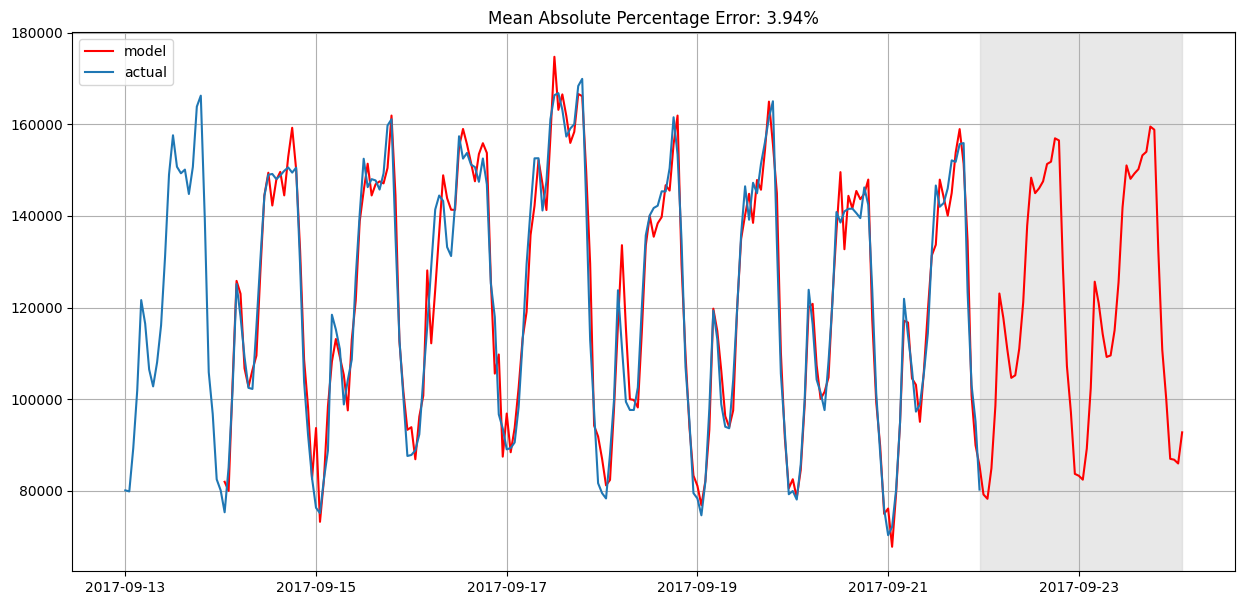

In [11]:
plotSARIMA(data, best_model, 50)